In [1]:
!pip install scipy


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from scipy.io import loadmat
annots = loadmat('dataset_liver_bmodes_steatosis_assessment_IJCARS.mat')
print(annots)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Aug 06 09:20:07 2018', '__version__': '1.0', '__globals__': [], 'data': array([[(array([[1]], dtype=uint8), array([[0]], dtype=uint8), array([[3]], dtype=uint8), array([[[0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                ...,
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0]],

               [[0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                ...,
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0]],

               [[0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                ...,
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
         

In [6]:
annots['data']['images']

array([[array([[[0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                ...,
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0]],

               [[0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                ...,
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0]],

               [[0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                ...,
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0]],

               ...,

               [[0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                [0, 0, 0, ..., 0, 0, 0],
                ...,
                [0, 0, 0, ..

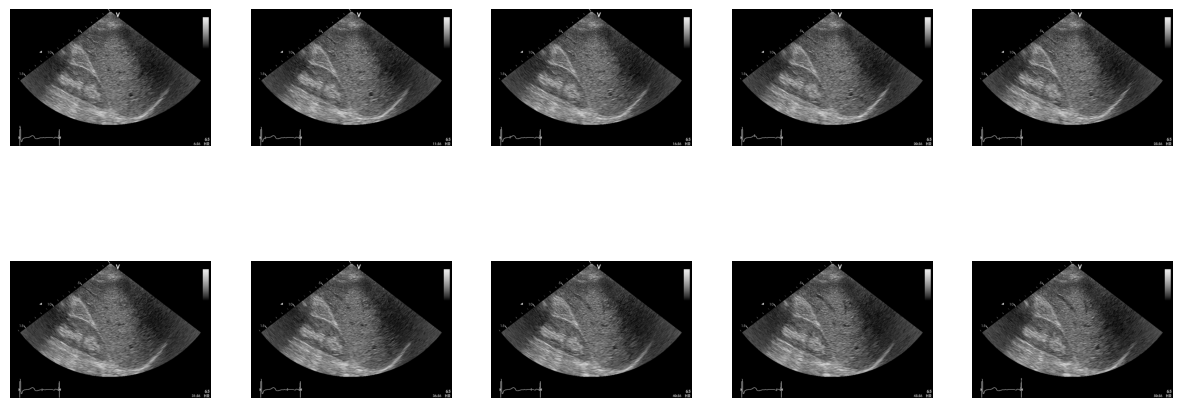

In [15]:
import matplotlib.pyplot as plt

# Assuming the loaded dataset is stored in the variable 'annots'
images = annots['data']['images'][0][0]
len(images[0])
# Display the 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i], cmap='gray')
    ax.axis('off')

plt.show()
